In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
%matplotlib inline

In [2]:
# Retreive all the data from the meta-data file
meta_data = ascii.read('../datared/J0600_meta-data.txt')

# To get nice plots, all the data is sorted by the epoch
epoch_tmp = np.array(meta_data["EPOCH"])
sort = np.argsort(epoch_tmp)
epoch = epoch_tmp[sort]

filters = np.array(meta_data["FILTER"])[sort] # Filters of all the .fits images
airmass = np.array(meta_data["AIRMASS"])[sort] # Airmasses for all the .fits images

fits_name = np.array(meta_data["IMAGE"])[sort] # Name of the original .fits file
files = np.array(meta_data["NEWIMG"])[sort] # Name of the data reduced files

N_files = len(epoch) #nr of files
N_stars = len(ascii.read(files[0])["STARNR"]) #nr of stars
print ("Number of files = {}".format(N_files))
print ("Number of stars = {}".format(N_stars))

Number of files = 45
Number of stars = 161


In [3]:
# Retreive the flux and fluxerr data from all the other files
flux_tmp = np.zeros((N_files,N_stars))
fluxerr_tmp = np.zeros((N_files,N_stars))

for i in range(N_files):
    file = files[i]
    
    filecontent = ascii.read(file)
    flux_tmp[i] = filecontent["FLUX"]
    fluxerr_tmp[i] = filecontent["FLUXERR"]

flux = flux_tmp
fluxerr = fluxerr_tmp

In [4]:
# Make a mask for all the filters:
dif_f = [] #list of the different filters
NimgINf_dict = {} #dictionary of number of images for each filter
for f in filters:
    if f not in dif_f:
        dif_f.append(f)
        NimgINf_dict[f] = 1
    else:
        NimgINf_dict[f] +=1
print (dif_f)
print (NimgINf_dict)

fmask = []
NimgINf = np.array([0]*len(dif_f)) # array of number of images for each filter
for i in range(len(dif_f)):
    fmask.append(filters == dif_f[i])
    NimgINf[i] = NimgINf_dict[dif_f[i]]

fmask = np.array(fmask)
print (NimgINf)

['gp', 'ip', 'rp']
{'gp': 15, 'ip': 15, 'rp': 15}
[15 15 15]


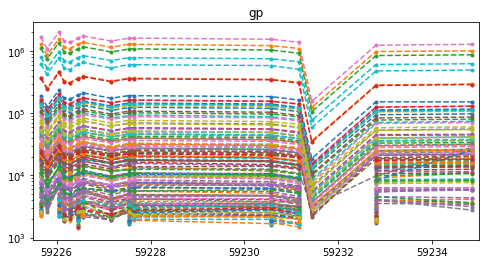

/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


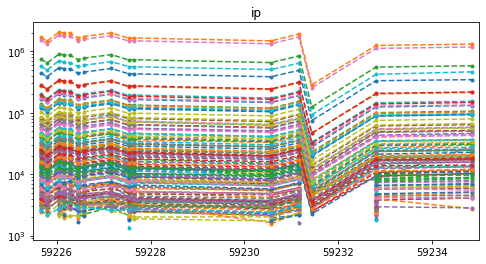

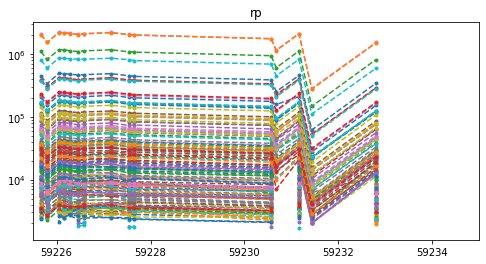

In [5]:
# Testing what the data looks like

# plotting all the flux against epoch for different filters
for i in range(len(dif_f)):
    plt.figure(figsize=(8,4))
    for j in range(0,N_stars):
        if (j+3)%10 !=0:
            plt.errorbar(epoch[fmask[i]],flux[fmask[i]][:,j], yerr=fluxerr[fmask[i]][:,j] ,fmt='--.', label="Star "+str(j))
    plt.title(dif_f[i])
    plt.axis(xmin=59225.5,xmax=59235)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.show()

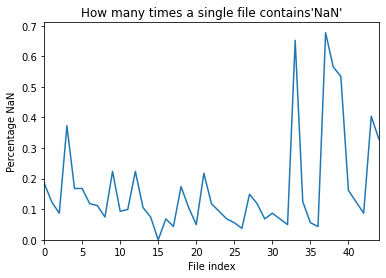

(3, 15, 161)
(3, 15)


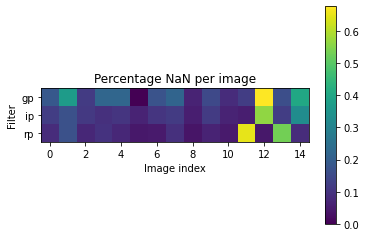

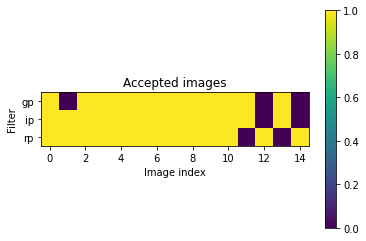

Excluded image in filter gp = 3
Excluded image in filter ip = 2
Excluded image in filter rp = 2


In [6]:
#Make a mask to filter bad photometry:
phot_nan = np.sum(np.isnan(flux), axis=1) #gives the number of 'NaN' for each file

plt.plot(phot_nan/N_stars)
plt.axis(xmin=0,ymin=0,xmax=N_files-1)
plt.title("How many times a single file contains'NaN'")
plt.xlabel("File index")
plt.ylabel("Percentage NaN")
plt.show()

# 
max_per_NaN = .25 # The maximum percentage of NaN before file is excluded
per_NaN = []
for i in range(len(dif_f)):
    per_NaN.append(np.isnan(flux[fmask[i]]))
per_NaN = np.array(per_NaN)
pmask = np.sum(per_NaN,axis=2)/N_stars <= max_per_NaN

print (np.shape(per_NaN))
print (np.shape(pmask))


plt.yticks(range(len(dif_f)),dif_f)
# There is a slight difference in epoch for each image so the xaxis cannot be labled as epoch
#plt.xticks(range(len(tmp[0])),np.round(epoch[fmask[0]],2),rotation=90)
plt.imshow(np.sum(per_NaN,axis=2)/N_stars)
plt.colorbar()
plt.title("Percentage NaN per image")
plt.ylabel("Filter")
plt.xlabel("Image index") 
plt.show()

plt.yticks(range(len(dif_f)),dif_f)
plt.imshow(pmask)
plt.colorbar()
plt.title("Accepted images")
plt.ylabel("Filter")
plt.xlabel("Image index")
plt.show()

for i in range(len(dif_f)):
    print ("Excluded image in filter {} = {}".format(dif_f[i], len(pmask[i])-np.sum(pmask,axis=1)[i]))


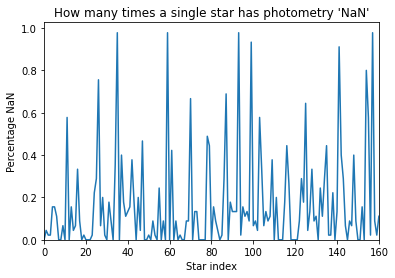

Number of stars without NaN in data = 46
Number of stars without NaN in data after exclusion bad photometry= 108


In [7]:
# Make a mask to filter bad stars
star_nan = np.sum(np.isnan(flux),axis=0) #gives the number of 'NaN' for each star

plt.plot(star_nan/N_files)
plt.axis(xmin=0,ymin=0,xmax=N_stars-1)
plt.title("How many times a single star has photometry 'NaN'")
plt.xlabel("Star index")
plt.ylabel("Percentage NaN")
plt.show()

# Making a mask for the stars without any NaN in their data after exclusion of bad fotometry images
star_withoutnan = np.sum(np.isnan(flux[phot_nan/N_stars <= max_per_NaN]), axis=0) == 0

print ("Number of stars without NaN in data = {}".format(np.sum(star_nan == 0)))
print ("Number of stars without NaN in data after exclusion bad photometry= {}".format(np.sum(star_withoutnan)))


In [8]:
# Simplifying the masks so combining the filter & photometry mask
fpmask = np.array([[0]*N_files]*len(dif_f),dtype=bool)
pmask_array = phot_nan/N_stars <= max_per_NaN

corepoch = [] # make a corrected epoch where the bad photometry is excluded
for i in range(len(dif_f)):
    fpmask[i] = fmask[i]*pmask_array
    corepoch.append(epoch[fpmask[i]])
print (np.shape(fpmask))
print (corepoch)

(3, 45)
[array([59225.6636414, 59226.0488858, 59226.1595608, 59226.2804254,
       59226.4547144, 59226.5732031, 59227.1634743, 59227.5350324,
       59227.6563471, 59230.5662052, 59231.15662  , 59232.7988534]), array([59225.6643716, 59225.7996727, 59226.0497182, 59226.1602757,
       59226.2811451, 59226.4555555, 59226.5739308, 59227.1642035,
       59227.5357551, 59227.6570723, 59230.5669301, 59231.1573503,
       59232.7995795]), array([59225.6650903, 59225.8003965, 59226.0504379, 59226.1609917,
       59226.2818588, 59226.4562817, 59226.5746507, 59227.1649187,
       59227.5364842, 59227.6577972, 59230.5676544, 59231.1580695,
       59232.8002971])]


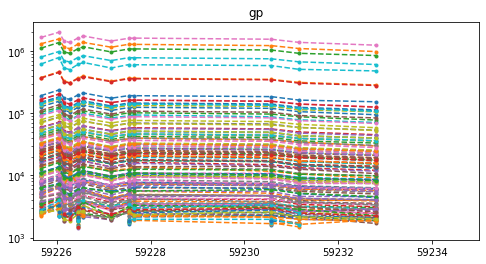

/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


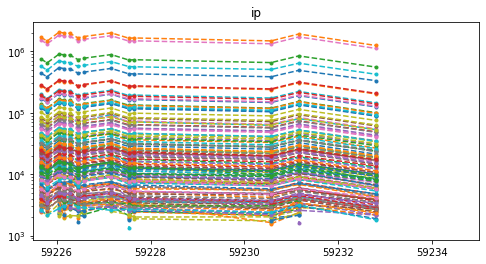

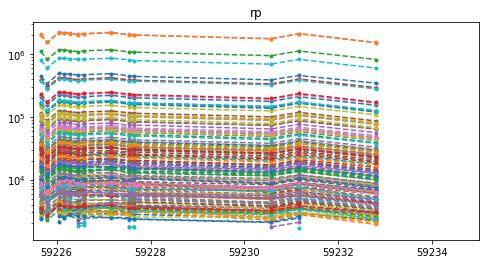

In [9]:
#plotting the flux against epoch for different filters with bad photometry files removed

for i in range(len(dif_f)):
    plt.figure(figsize=(8,4))
    for j in range(0,N_stars):
        if (j+3)%10 !=0:
            plt.errorbar(corepoch[i],flux[fpmask[i]][:,j], yerr=fluxerr[fpmask[i]][:,j],\
                         fmt='--.', label="Star "+str(j))
    plt.title(dif_f[i])
    plt.axis(xmin=59225.5,xmax=59235)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.show()

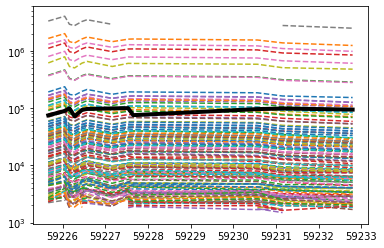

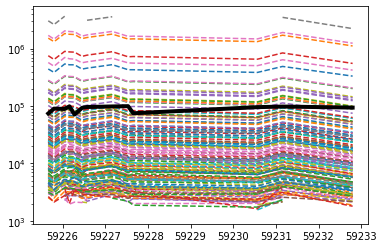

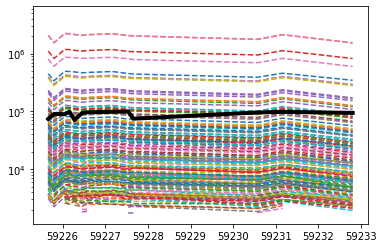

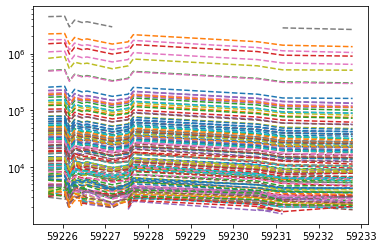

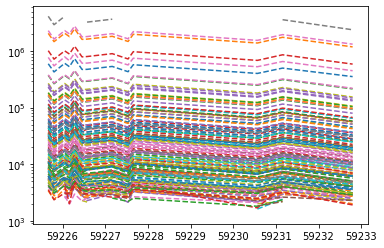

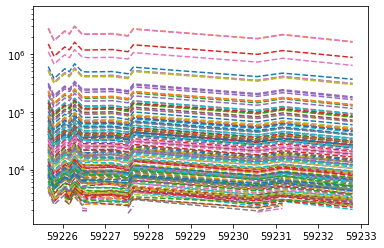

In [10]:
# In this cell I plot the airmass inbetween all the fluxes and then I plot the flux mulitplied by the airmass
#  This does kind of make sense, but the observed flux is also influenced by other things than airmass
#  (e.g. integration time). According to the 
for j in range(len(dif_f)):
    plt.plot(corepoch[j],flux[fpmask[j]],linestyle='dashed')
    plt.plot(corepoch[j], 1/airmass[fpmask[j]]*1e5,linewidth=4,c='black')
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.show()

for j in range(len(dif_f)):
    for i in range(N_stars):
        plt.plot(corepoch[j],flux[fpmask[j]][:,i]*airmass[fpmask[j]],linestyle='dashed')
    #plt.plot(epoch[fmask[j]][pmask[j]], 1/airmass[fmask[j]][pmask[j]]*1e5,linewidth=4,c='black')
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.show()

In [19]:
#I want to plot the normalised flux so I first want to devide the flux of all stars by their own mean.

# Calculate the mean flux for each star
meanflux_star = []
for i in range(len(dif_f)):
    tmp = []
    for j in range(N_stars):
        tmp.append(np.mean(flux[fpmask[i]][:,j]))
    meanflux_star.append(tmp)
meanflux_star = np.array(meanflux_star)
print (np.shape(meanflux_star))


#Then I want to devide the fluxes of all stars at one epoch by the normalised mean of all stars at that epoch.
# If the stars are all constant, it should result in a straight line.

# Calculate the mean normalised flux for each epoch
meanflux_epoch = []
for i in range(len(dif_f)):
    tmp = []
    for j in range(np.sum(fpmask[i])):
        #Exclude the NaN's for the mean
        tmp.append(np.mean((flux[fpmask[i]][j]/meanflux_star[i])[star_withoutnan]))
    meanflux_epoch.append(tmp)

# Calculate the flux of each star, corrected by the normalised mean flux at a certain epoch
corflux = []
for i in range(len(dif_f)):
    tmp = []
    for j in range(N_stars):
        tmp.append(flux[fpmask[i]][:,j]/np.array(meanflux_epoch[i]))
    corflux.append(np.array(tmp).transpose())
print (np.shape(corflux[0]))

(3, 161)
(12, 161)


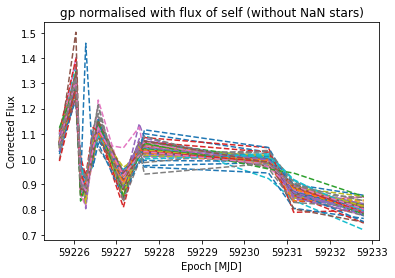

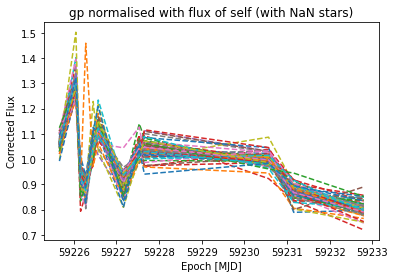

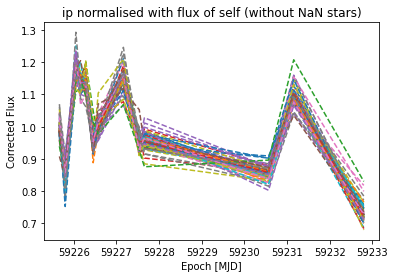

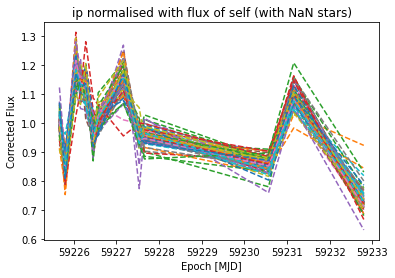

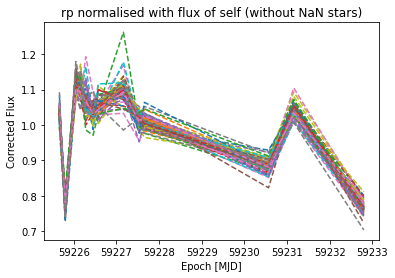

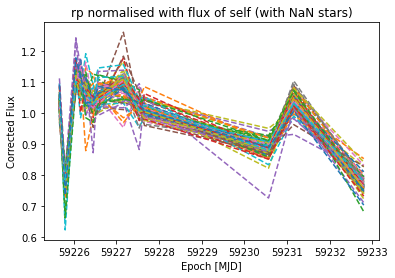

In [20]:
#Plot the flux of all stars normalised with their own flux to check if it worked
for i in range(len(dif_f)):
    for j in np.arange(N_stars)[star_withoutnan]:
        plt.plot(corepoch[i],flux[fpmask[i]][:,j]/np.array(meanflux_star[i,j]),linestyle='dashed')
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
    plt.title(dif_f[i]+" normalised with flux of self (without NaN stars)")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    for j in np.arange(N_stars):#[star_withoutnan]:
        plt.plot(corepoch[i],flux[fpmask[i]][:,j]/np.array(meanflux_star[i,j]),linestyle='dashed')
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
    plt.title(dif_f[i]+" normalised with flux of self (with NaN stars)")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()

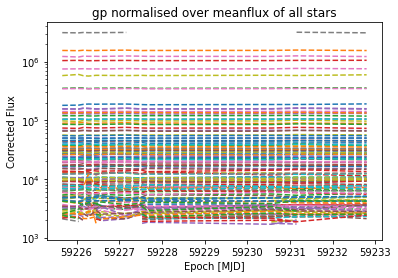

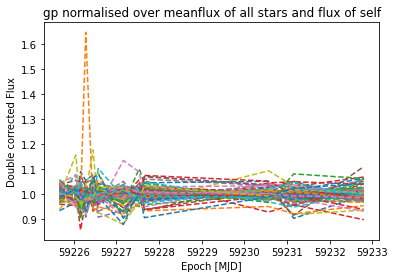

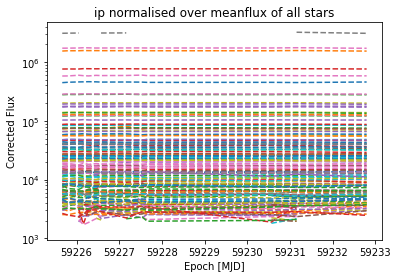

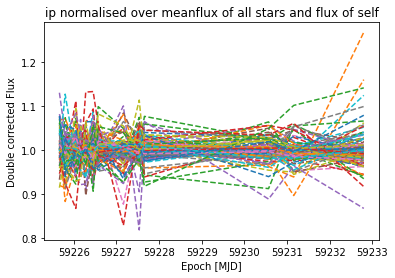

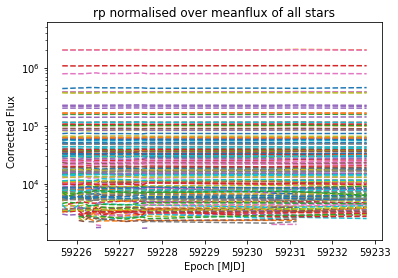

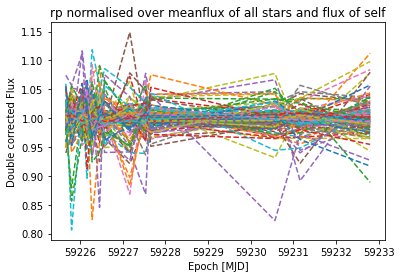

In [22]:
#Plot the epoch-corrected stellar flux.
#Also plot the double corrected plots (which is a straight line for constant stars)
for i in range(len(dif_f)):
    for j in np.arange(N_stars):#[star_withoutnan]:
        plt.plot(corepoch[i],corflux[i][:,j],linestyle='dashed')
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(dif_f[i]+" normalised over meanflux of all stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    for j in np.arange(N_stars):#[star_withoutnan]:
        plt.plot(corepoch[i],corflux[i][:,j]/np.array(meanflux_star[i,j]),\
                 linestyle='dashed', label="star "+str(j))
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
    plt.title(dif_f[i]+" normalised over meanflux of all stars and flux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Double corrected Flux")
    plt.show()